# AAI 628 Final Project
## Deep Learning Dog vs. Cat Classifier - Simple CNN
### Tim Demetriades
December 16th, 2021

In this first notebook a **simple CNN** model will be used to try to make the predictions.

First we import all of the needed packages/modules.

In [1]:
import os
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import cv2
import pickle
from PIL import Image

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

These are the paths where the training and test zip files are located.

In [3]:
train_zip = r"C:\Users\timjr\Documents\Python\Deep Learning\Final_Project\dogs-vs-cats\train.zip"
test_zip = r"C:\Users\timjr\Documents\Python\Deep Learning\Final_Project\dogs-vs-cats\test1.zip"

Below we unzip the train and test files to the working directory.

In [ ]:
if not os.path.exists('train'):
    with zipfile.ZipFile(train_zip, 'r') as z:
        z.extractall('.')
if not os.path.exists('test'):
    with zipfile.ZipFile(test_zip, 'r') as z:
        z.extractall('.')

Here we grab the filenames and the labels from the filenames. Since each file is in the form 'cat.123.jpg' or 'dog.123.jpg', we can split on the '.' to grab either 'cat' or 'dog'. We can then **assign a 0 to 'cat' and a 1 to 'dog'**.

For the test images we just grab the filenames.

In [28]:
train_folder = r"train"
filenames = os.listdir(train_folder)
test_folder = r"test1"
filenames_test = os.listdir(test_folder)

labels = []
for file in filenames:
    label = file.split('.')[0]
    if label == 'cat':
        labels.append(0)    # 0 = cat
    else:
        labels.append(1)    # 1 = dog 

A Pandas dataframe is created of the **filenames** and their **labels** (either 0 or 1) for the train data.

Another dataframe is created of just the **filenames** for the test data.

In [29]:
train_df = pd.DataFrame({'filename': filenames, 'label': labels})

In [6]:
train_df

filename  label
0         cat.0.jpg      0
1         cat.1.jpg      0
2        cat.10.jpg      0
3       cat.100.jpg      0
4      cat.1000.jpg      0
...             ...    ...
24995  dog.9995.jpg      1
24996  dog.9996.jpg      1
24997  dog.9997.jpg      1
24998  dog.9998.jpg      1
24999  dog.9999.jpg      1

[25000 rows x 2 columns]

In [30]:
test_df = pd.DataFrame({'filename': filenames_test})
test_df

filename
0          1.jpg
1         10.jpg
2        100.jpg
3       1000.jpg
4      10000.jpg
...          ...
12495   9995.jpg
12496   9996.jpg
12497   9997.jpg
12498   9998.jpg
12499   9999.jpg

[12500 rows x 1 columns]

This is what the first image looks like. As you can see we set the target size to **100x100**, which is smaller than the original image but still big enough to determine it is a cat.

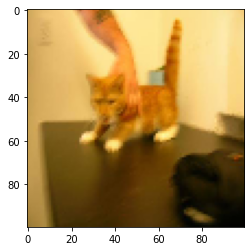

In [84]:
# Show first train image
image = load_img(os.path.join(train_folder, filenames[0]), target_size = (100, 100))
plt.imshow(image)

Here is where we get the pixels values from the actual images and convert them load them into a list. Since there are so many images and each image can contain a lot of pixels this operation usually takes a fair amount of time. For this reason we use Pickle afterwards to save the data to a file so we can load it in afterwards without having to repeat this process.

You might notice the images are also are resized to **100x100** so that they can all be the same size (**square images**) and smaller and therefore more efficient. This size seems to be the best tradeoff between speed and accuracy. Looking at the 100x100 images you can still determine if they are of a cat of a dog by eye.

In [8]:
IMAGE_SIZE = 100
IMAGE_CHANNELS = 3

In [ ]:
# Train data
image_data = []
for row in train_df.values:
    image_path = os.path.join(train_folder, row[0])
    image_array = cv2.imread(image_path)
    image_array = cv2.resize(image_array, (IMAGE_SIZE, IMAGE_SIZE))
    image_data.append([image_array, row[1]])

In [ ]:
print(len(image_data))

In [31]:
# Test data
image_data = []
for row in test_df.values:
    image_path = os.path.join(test_folder, row[0])
    image_array = cv2.imread(image_path)
    image_array = cv2.resize(image_array, (IMAGE_SIZE, IMAGE_SIZE))
    image_data.append(image_array)

In [32]:
print(len(image_data))

12500


We load the **train image** arrays into the `x` NumPy array and their corresponding labels into the `y` NumPy array.

In [ ]:
x = []
y = []

for image, label in image_data:
    x.append(image)
    y.append(label)
    
x = np.array(x)
y = np.array(y)

We load the **test images** into the `x_test` NumPy array.

In [33]:
x_test = []

for image in image_data:
    x_test.append(image)

x_test = np.array(x_test)

We **normalize** the pixel values by dividing by the max pixel value so that they are all between 0 and 1.

Since we normalize the train images we also have to normalize the test images.

In [ ]:
# Normalize train images
x = x / 255

In [36]:
# Normalize test images
x_test = x_test / 255

This is where the **data is saved to a file** with pickle so that it can be loaded later on without having to repeat the long process of loading in the pixel data from each image.

In [37]:
# Write a pickled representation of obj to the open file object file.
# This is used since loading all the images takes a long time
# pickle.dump(x, open('x.pkl', 'wb'))
# pickle.dump(y, open('y.pkl', 'wb'))
# pickle.dump(x_test, open('x_test.pkl', 'wb'))

# To load pickled data:
x = pickle.load(open('x.pkl', 'rb'))
y = pickle.load(open('y.pkl', 'rb'))
x_test = pickle.load(open('x_test.pkl', 'rb'))

Here is a **simple CNN** model. It contains **3 convolution layers with 64 filters and filter sizes of 3x3** each. Each convolution is also followed by **batch normalization** to normalize and make the network faster and more stable, **max pooling** to reduce the dimensionality, and **dropout** to prevent overfitting. After the convolutions the data is **flattened** and fed to **3 dense fully-connected layers**, the first two having **relu activations** and the final having **softmax activation** so that we can get a final prediction of whether the image is a dog or a cat. The **final layer** of course has **2 neurons** as there are two possibilites - dog or cat.

In [10]:
# Create basic CNN model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
          
model.add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0

Below we define two objects. 

`checkpoint` is an object that will save checkpoints of the model as it is being trained. It will save the model only if the accuracy has increased after the current batch.
`early` is an object that will stop the training when a certain metric has stopped improving. We will use the validation accuracy here to prevent overfitting as it is possible for the training accuracy to increase even after the validation accuracy has reached a maximum (**overfitting**).

In [12]:
checkpoint = ModelCheckpoint(filepath = 'model_1.h5', 
                             monitor = 'accuracy', 
                             verbose = 0, 
                             save_best_only = True, 
                             save_freq = 5)
early = EarlyStopping(monitor = 'val_accuracy', patience = 3, verbose = 1)

We configure the model for training with the **adam optimizer** which we have found from experience to be one of the better optimizers. We also use the **sparse categorical crossentropy loss function** as the predictions are binary (either 0 or 1). Finally we evaluate on the **accuracy metric**.

The model is then trained with the data, splitting the data into **85% training data and 15% validation data** so that we can validate the model's performance during training.

In [13]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x, y, 
                    epochs = 20, 
                    validation_split = 0.15, 
                    batch_size = 32, 
                    callbacks = [checkpoint, early])

Epoch 1/20
665/665 [==============================] - 280s 420ms/step - loss: 0.6582 - accuracy: 0.6832 - val_loss: 1.4371 - val_accuracy: 0.1800
Epoch 2/20
665/665 [==============================] - 287s 432ms/step - loss: 0.4853 - accuracy: 0.7674 - val_loss: 0.9325 - val_accuracy: 0.4547
Epoch 3/20
665/665 [==============================] - 292s 439ms/step - loss: 0.3972 - accuracy: 0.8197 - val_loss: 0.8281 - val_accuracy: 0.5680
Epoch 4/20
665/665 [==============================] - 282s 423ms/step - loss: 0.3345 - accuracy: 0.8498 - val_loss: 1.3569 - val_accuracy: 0.4221
Epoch 5/20
665/665 [==============================] - 272s 408ms/step - loss: 0.2789 - accuracy: 0.8804 - val_loss: 0.8133 - val_accuracy: 0.6112
Epoch 6/20
665/665 [==============================] - 272s 410ms/step - loss: 0.2314 - accuracy: 0.9032 - val_loss: 0.4023 - val_accuracy: 0.8379
Epoch 7/20
665/665 [==============================] - 278s 418ms/step - loss: 0.1785 - accuracy: 0.9276 - val_loss: 0.5115 -

As can be seen above, the **training accuracy steadily increased** as expected. However, the **validation accuracy fluctuated**. Although it did finish relatively high at **84.51% after 14 epochs**, the model achieved the highest validation accuracy after 11 epochs with **87.41%**. Since we used the early stopping callback, the model stopped training after 3 epochs of no improvement in the validation accuracy.

This flunctuation in the validation accuracy could be a result of the random nature of the validation split as the data is shuffled after each epoch.

Below are plots for the **loss and accuracy**.

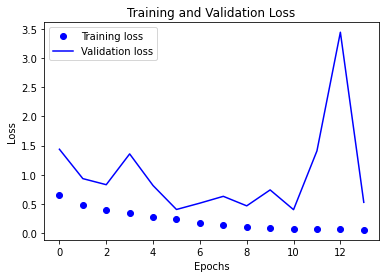

In [25]:
# Plot loss
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
plt.plot(loss_values, 'bo', label='Training loss')
plt.plot(val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Plot Accuracy
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
plt.plot(acc_values, 'b', label='Training Accuracy')
plt.plot(val_acc_values, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The above graphs help show the results of the model. You can clearly see the fluctuations in the validation loss and accuracy. A big difference in the training and validation accuracy would lead one to assume the model is **overfit**. However, it is hard to tell this is the case due to the fact that while some validation accuracies are far from the training accuracy, others are much closer.

Either way, our model ended with a solid **validation accuracy** of around **85%**. Let's try to make **predictions** now with the test data.

In [40]:
predictions = model.predict(x_test, verbose = 1)

391/391 [==============================] - 162s 415ms/step


`predictions` is an array of 12,500 rows and two columns. For each row the value in each column indicates the prediction - if the first number is higher it predicts a cat, if the second number is higher it predicts a dog.

We use `argmax` to get the index of the higher column to get our results: **0 means it predicts a cat, 1 means it predicts a dog**.

In [67]:
np.argmax(predictions, axis = 1)

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

We add the predictions to the test_df by adding a new column, `label` and putting the corresponding prediction for each image in that column.

In [68]:
test_df['label'] = np.argmax(predictions, axis = 1)

In [69]:
test_df

filename  label
0          1.jpg      1
1         10.jpg      0
2        100.jpg      0
3       1000.jpg      1
4      10000.jpg      1
...          ...    ...
12495   9995.jpg      1
12496   9996.jpg      1
12497   9997.jpg      1
12498   9998.jpg      0
12499   9999.jpg      0

[12500 rows x 2 columns]

Let's grab a **sample of the images** and display them with their **corresponding predictions** to see how well the model did on images it wasn't trained on. Remember, 0 means cat and 1 means dog.

In [74]:
sample_test = test_df.sample(n=9).reset_index()    # grab 9 random rows from the df
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    label = row['label']
    image = load_img("test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(image)                                        # display the image
    plt.xlabel(filename + '(' + "{}".format(label) + ')')    # display the filename and prediction
plt.tight_layout()
plt.show()

Above you can see that **for all 9 images in the sample above the model was able to correctly classify them as either a cat or a dog**. Of course, as we saw the validation accuracy was only around 85%, but for the 9 samples above it was 100% accurate.

Now let's create a dataframe for the final results and save them to a **csv file**.

In [77]:
results_df = test_df.copy()
results_df['id'] = results_df['filename'].str.split('.').str[0]
results_df.drop(['filename'], axis = 1, inplace = True)
results_df = results_df[['id', 'label']]   # make sure this is the order
results_df.to_csv('results.csv', index = False) 

In [86]:
results_df.head()

id  label
0      1      1
1     10      0
2    100      0
3   1000      1
4  10000      1

Overall the model did a solid job of classifying images of cats and dogs. We obtained a very high **training accuracy** of **98%**, but of course what really matters if the **validation accuracy** which was around **85%**. Although good, this difference can be a result of overfitting to the training data. This means that the model is starting to memorize the training data rather than just picking up meaningful features and correlations.

There are several ways of preventing this. One method is using **dropout**, which we actually used in our model. This makes the model simpler and helps prevent it from just memorizing the training data. It is a form of regularization. 

Another thing we can try is **data augmentation**, which is essentially taking our images and applying transformations such as flipping, rotating, cropping, shifting, etc. This is an easy way to increase the amount of training data without actually needing to get more images.

Finally, we can also try **transfer learning with a pretrained model**. This is where we take an existing model, such as VGG16, and only train the top fully connected layers with our data. Since VGG16 is very deep it would be very hard to train manually with this data. It would take a very long time, especially without a GPU, and would likely be prone to overfitting. Hence, we will use a **pre-trained VGG16 model trained on the ImageNet dataset** (14,000,000 iamges with labels) and do transfer learning.

Let's try adding both **data augmentation** by using generators and also try **transfer learning**.

At first I tried this in this notebook using my computer's CPU to train, but this took very long (around an hour per epoch). Therefore I switched to using Google Colab and the GPU runtime (which took only around 2.5 minutes per epoch). The rest of this notebook is continued on there.